In [19]:
import time, os, math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [29]:
def LAPLACIAN_JACOBI(phi_old, source, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx):
    return 0.25*(phi_old[neighbor_r[idx]]+phi_old[neighbor_l[idx]]+phi_old[neighbor_u[idx]]+phi_old[neighbor_d[idx]]\
                 -dx**2*source[idx])
    
def LAPLACIAN_GAUSS_SEIDEL(phi_old, source, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_even, idx_odd):
    phi_old[idx_even] = 0.25*(phi_old[neighbor_r[idx_even]]+phi_old[neighbor_l[idx_even]]\
                              +phi_old[neighbor_u[idx_even]]+phi_old[neighbor_d[idx_even]]-dx**2*source[idx_even])
    phi_old[idx_odd] = 0.25*(phi_old[neighbor_r[idx_odd]]+phi_old[neighbor_l[idx_odd]]\
                             +phi_old[neighbor_u[idx_odd]]+phi_old[neighbor_d[idx_odd]]-dx**2*source[idx_odd])
    return phi_old

def LAPLACIAN_SUCCESSIVE_OVER_RELAXATION(phi_old, omega, source, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_even, idx_odd):
    phi_old[idx_even] += 0.25*omega*(phi_old[neighbor_r[idx_even]]+phi_old[neighbor_l[idx_even]]+phi_old[neighbor_u[idx_even]]\
                                     +phi_old[neighbor_d[idx_even]]-dx**2*source[idx_even]-4.*phi_old[idx_even])
    phi_old[idx_odd] += 0.25*omega*(phi_old[neighbor_r[idx_odd]]+phi_old[neighbor_l[idx_odd]]+phi_old[neighbor_u[idx_odd]]\
                                     +phi_old[neighbor_d[idx_odd]]-dx**2*source[idx_odd]-4.*phi_old[idx_odd])
    return phi_old
    
def CALCULATE_CRITERIA(phi, source, neighbor_r, neighbor_l, neighbor_u, neighbor_d):
    diff = (1./dx**2*(phi[neighbor_r]+phi[neighbor_l]+phi[neighbor_u]+phi[neighbor_d]-4.*phi)-source)[boundary==False]
    return (diff**2).mean()

def CHECKER_BOARD(N):
    A = np.arange(N*N//2)
    X = (2*A)%N
    Y = (2*A)//N
    P = (X+Y+1)%2
    X += P
    ODD_INDEX = (X + Y*N).copy()
    ODD_INDEX = ODD_INDEX[((ODD_INDEX//N!=N-1)&(ODD_INDEX//N!=0)&(ODD_INDEX%N!=N-1)&(ODD_INDEX%N!=0))]
    
    X = (2*A)%N
    Y = (2*A)//N
    P = (X+Y)%2
    X += P
    EVEN_INDEX = (X + Y*N).copy()
    EVEN_INDEX = EVEN_INDEX[((EVEN_INDEX//N!=N-1)&(EVEN_INDEX//N!=0)&(EVEN_INDEX%N!=N-1)&(EVEN_INDEX%N!=0))]
    return EVEN_INDEX, ODD_INDEX

In [35]:
phi

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.86912281,  1.72547979,  2.55398049,  3.33689698,
         4.05352252,  4.67979557,  5.18788383,  5.54572421,  5.71651383,
         5.65814713,  5.32259384,  4.65521172,  3.59398786,  2.06870141,
         0.        ],
       [ 0.        ,  1.50986577,  2.99756626,  4.43688717,  5.79702926,
         7.04201756,  8.13004851,  9.0127675 ,  9.63446949,  9.93121455,
         9.82984982,  9.24692852,  8.08751571,  6.24386987,  3.59398786,
         0.        ],
       [ 0.        ,  1.95560704,  3.88251626,  5.74677729,  7.50849771,
         9.1210798 , 10.53037559, 11.67375134, 12.47905205, 12.86345574,
        12.73220632, 11.97721312, 10.47550371,  8.08751571,  4.65521172,
         0.        ],
       [ 0.        ,  2.23587435,  4

In [43]:
L = 1.0
N = 64
dx = dx = L/(N-1)
x = np.arange(0,N)
y = np.arange(0,N)
xx,yy= np.meshgrid(x,y)

phi_analytic = np.exp(dx*xx-dx*yy)*dx*xx*(1.-dx*xx)*dx*yy*(1.-dx*yy)
rho = (2*dx*xx*(dx*yy-1.)*(dx*yy-2.*dx*xx+dx*xx*dx*yy+2.)*np.exp(dx*xx-dx*yy)).ravel()
# phi_analytic = (1.0-yy)

phi = np.zeros(N*N)

boundary = ((yy%N==0) | (yy%N==N-1) | (xx%N==0) | (xx%N==N-1)).ravel()
phi[boundary] = phi_analytic.ravel()[boundary]
iteration = 0
iteration_max = 4000000
show_error_interval = 100
# mode = 'jacobi'
# mode = 'gauss_seidel'
mode = 'SOR'

neighbor_r = np.arange(N*N)
neighbor_l = np.arange(N*N)
neighbor_u = np.arange(N*N)
neighbor_d = np.arange(N*N)
neighbor_r = N*(neighbor_r//N) + (neighbor_r%N+1)%N
neighbor_l = N*(neighbor_l//N) + (neighbor_l%N+N-1)%N
neighbor_u = N*((neighbor_u//N+1)%N) + neighbor_u%N
neighbor_d = N*((neighbor_d//N+N-1)%N) + neighbor_d%N

# criteria = CALCULATE_CRITERIA(phi_analytic.ravel(), rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
criteria = 1e-21
error = CALCULATE_CRITERIA(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
print("Lattice size = %d using %s scheme:"%(N, mode))
if mode=='jacobi':
    phi_copy = phi.copy()
    flag = True
    #     idx_boundary = boundary==False
    idx_not_boundary = np.argwhere(boundary==False).reshape(-1)
elif mode=='gauss_seidel' or mode=='SOR':
    idx_even, idx_odd = CHECKER_BOARD(N)
    if mode == 'SOR':
        omega = 1.9
start = time.time()
while error>criteria and iteration<iteration_max:
    if mode=='jacobi':
        if flag:
            phi_copy[boundary==False] = LAPLACIAN_JACOBI(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_not_boundary)
            error = CALCULATE_CRITERIA(phi_copy, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
        else:
            phi[boundary==False] = LAPLACIAN_JACOBI(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_not_boundary)
            error = CALCULATE_CRITERIA(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
        flag = not flag
    elif mode=='gauss_seidel':
        phi = LAPLACIAN_GAUSS_SEIDEL(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_even, idx_odd)
        error = CALCULATE_CRITERIA(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
    else:
        phi = LAPLACIAN_SUCCESSIVE_OVER_RELAXATION(phi, omega, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_even, idx_odd)
        error = CALCULATE_CRITERIA(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
    iteration += 1
    if iteration%show_error_interval == 0:
        print("Iteration = %d, error = %.4e , criteria = %.4e ."%(iteration, error, criteria))
if mode=='jacobi':
    if flag:
        phi = phi.copy()
end = time.time()

print("\tSimulation of %s scheme ends. Total %.2f s is spent."%(mode, end-start))
print("\tError %.4e has been reached, total iterations is %d ."%(error, iteration))
print("\tError with analytic solution is %.8e ."%(((phi-phi_analytic.ravel())**2).mean())**0.5)
phi = np.array(phi.reshape(N,N))

Lattice size = 64 using SOR scheme:
Iteration = 100, error = 1.0219e-03 , criteria = 1.0000e-21 .
Iteration = 200, error = 6.2791e-10 , criteria = 1.0000e-21 .
Iteration = 300, error = 3.8499e-16 , criteria = 1.0000e-21 .
	Simulation of SOR scheme ends. Total 0.05 s is spent.
	Error 9.8726e-22 has been reached, total iterations is 390 .
	Error with analytic solution is 4.43490773e-06 .


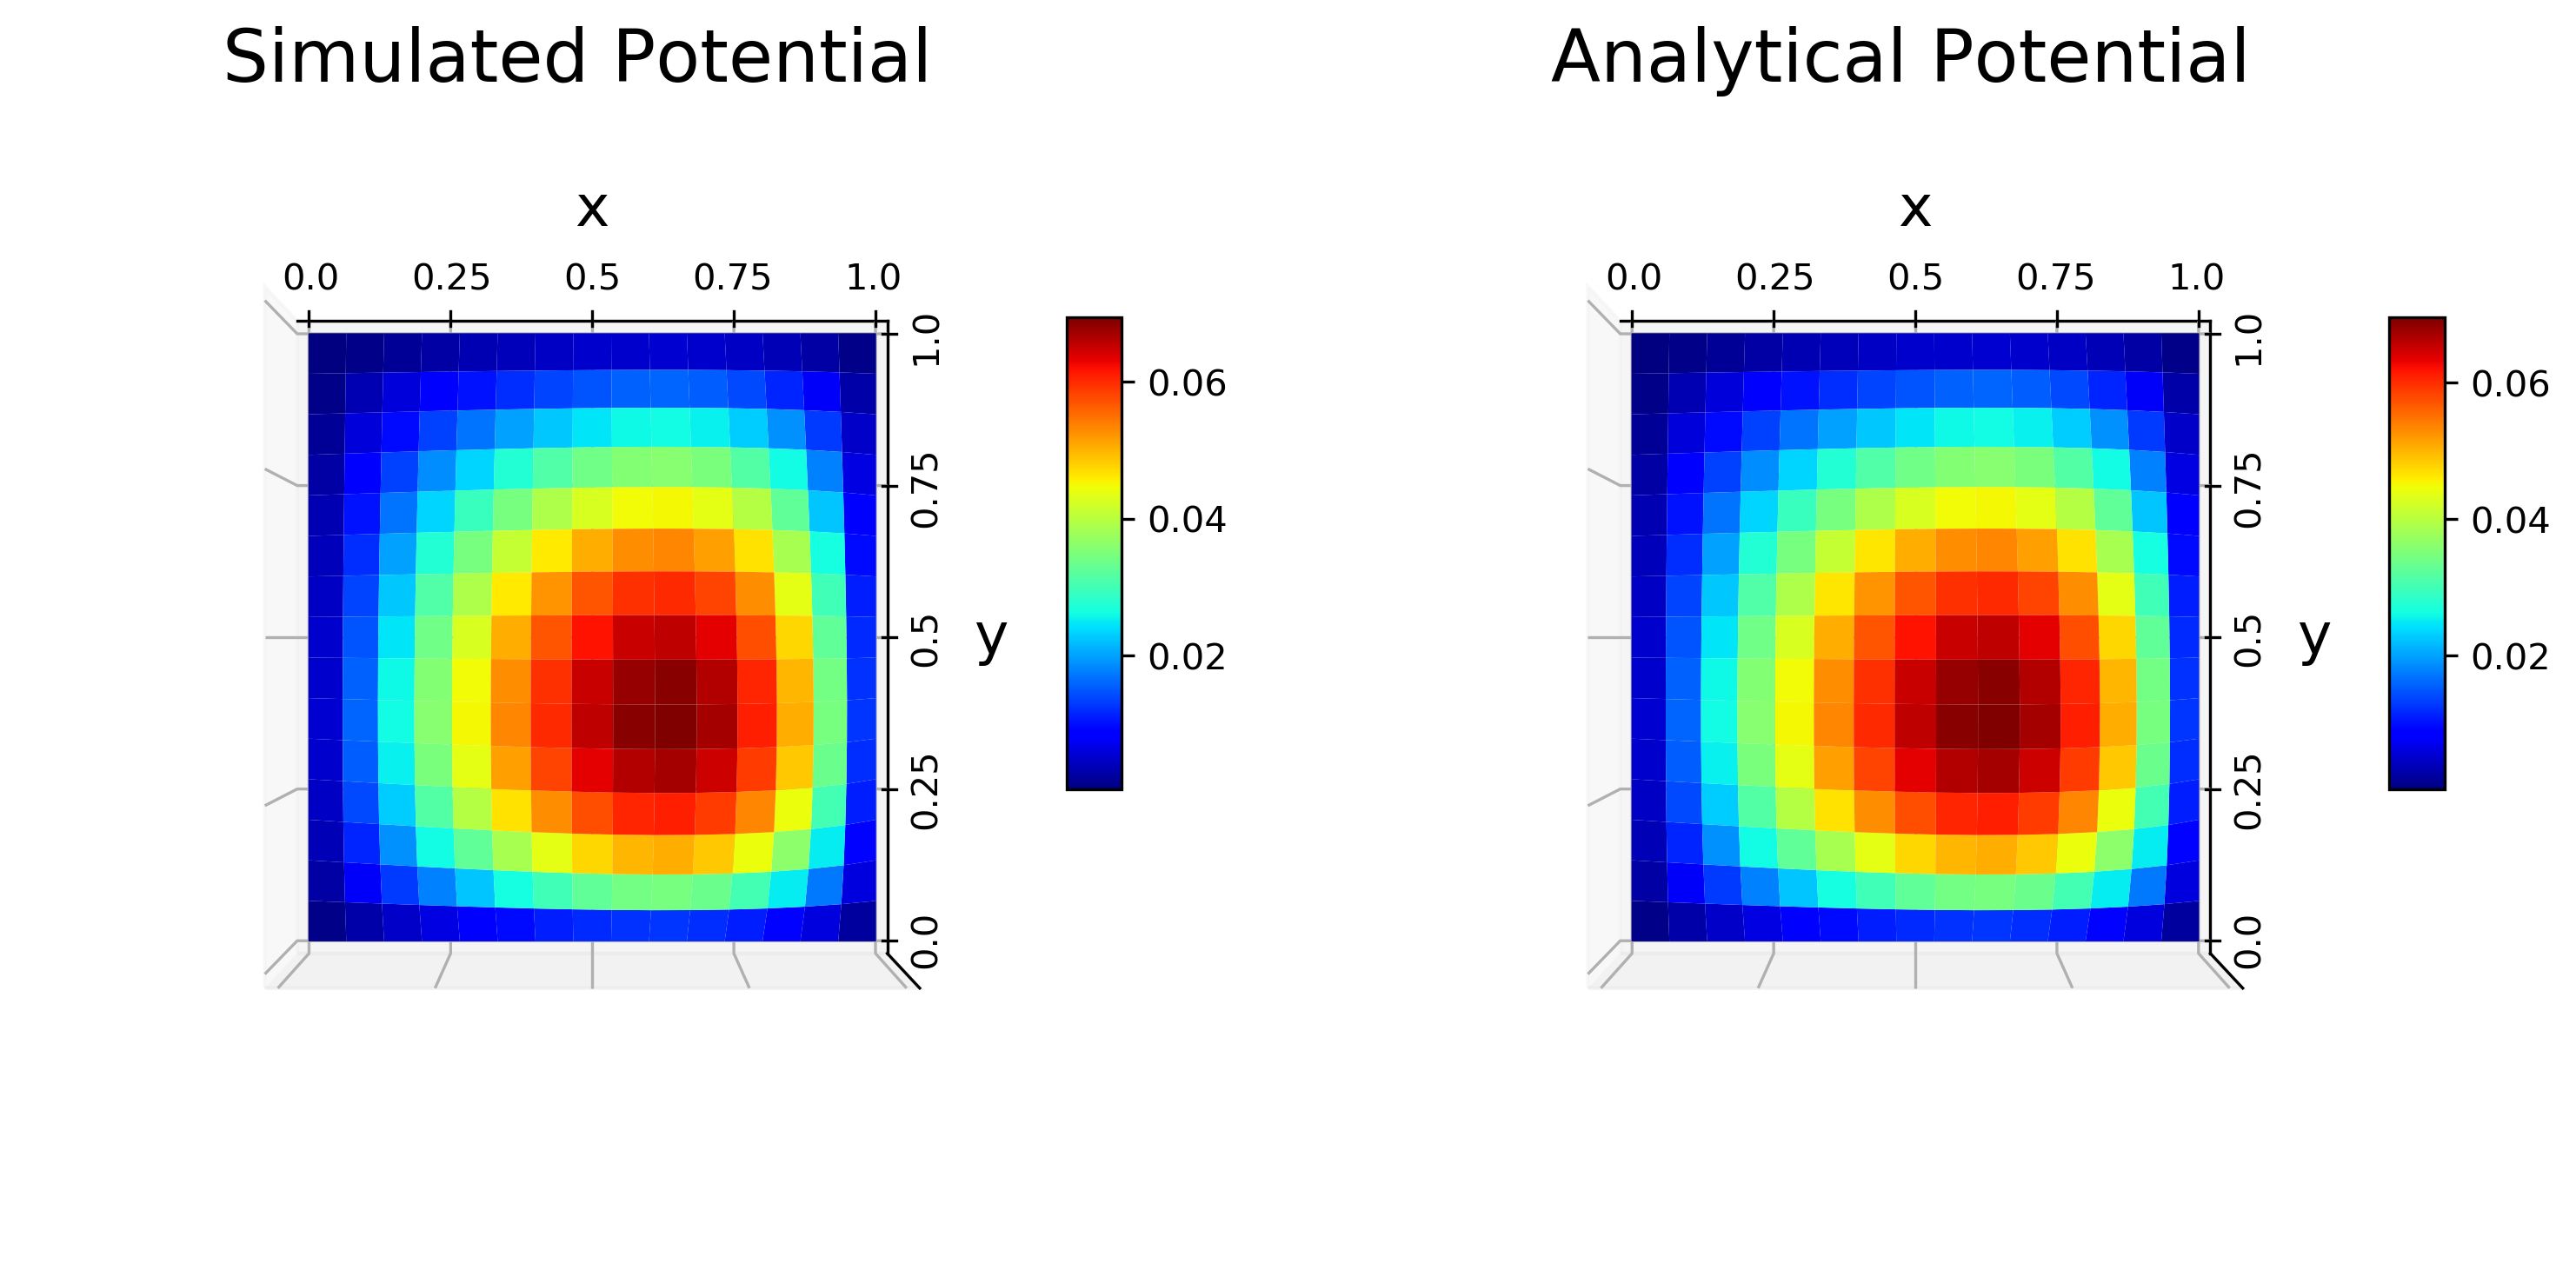

In [37]:
fig = plt.figure(figsize=(2*6,6), dpi=300)

ax_1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax_1.plot_surface(dx*xx, dx*yy, phi, cmap='jet', edgecolor='none', )
ax_1.set_title('Simulated Potential', fontsize=20, y=1.05)
ax_1.view_init(90,-90)
ax_1.axis('tight')
ax_1.set_xlim([0,L])
ax_1.set_ylim([0,L])
ax_1.set_xticks(np.linspace(0,L,5))
ax_1.set_yticks(np.linspace(0,L,5))
ax_1.set_xticklabels(np.linspace(0,L,5), fontsize=10., va='center')
ax_1.set_yticklabels(np.linspace(0,L,5), fontsize=10., va='center', rotation=90)
ax_1.set_zticks([])
ax_1.set_xlabel('x', labelpad=10, fontsize=16)
ax_1.set_ylabel('y', labelpad=10, fontsize=16)
axins_1 = inset_axes(ax_1,
                    width="5%",  # width = 50% of parent_bbox width
                    height="40%",  # height : 5%
                    loc='upper right',
                    bbox_to_anchor=(0.01, -0.2, 1, 1), #(position_x, position_y, bbox_size_x, bbox_size_y)
                    bbox_transform=ax_1.transAxes)
fig.colorbar(surf, shrink=0.3, aspect=10, cax=axins_1)

ax_2 = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax_2.plot_surface(dx*xx, dx*yy, phi_analytic, cmap='jet', edgecolor='none', )
ax_2.set_title('Analytical Potential', fontsize=20, y=1.05)
ax_2.view_init(90,-90)
ax_2.axis('tight')
ax_2.set_xlim([0,L])
ax_2.set_ylim([0,L])
ax_2.set_xticks(np.linspace(0,L,5))
ax_2.set_yticks(np.linspace(0,L,5))
ax_2.set_xticklabels(np.linspace(0,L,5), fontsize=10., va='center')
ax_2.set_yticklabels(np.linspace(0,L,5), fontsize=10., va='center', rotation=90)
ax_2.set_zticks([])
ax_2.set_xlabel('x', labelpad=10, fontsize=16.)
ax_2.set_ylabel('y', labelpad=10, fontsize=16.)
axins_2 = inset_axes(ax_2,
                    width="5%",  # width = 50% of parent_bbox width
                    height="40%",  # height : 5%
                    loc='upper right',
                    bbox_to_anchor=(0.01, -0.2, 1, 1), #(position_x, position_y, bbox_size_x, bbox_size_y)
                    bbox_transform=ax_2.transAxes)
fig.colorbar(surf, shrink=0.3, aspect=10, cax=axins_2)
# plt.savefig("/home/lab/Guan_Ming/Computational_Astrophysics/Homework/HW3/Problem_1_Simulated_v.s._Analytic_Potential_N=256_criteria=1.00000000e-21.png", bbox_inches='tight', dpi=200, pad_inches=0.05)
plt.show()

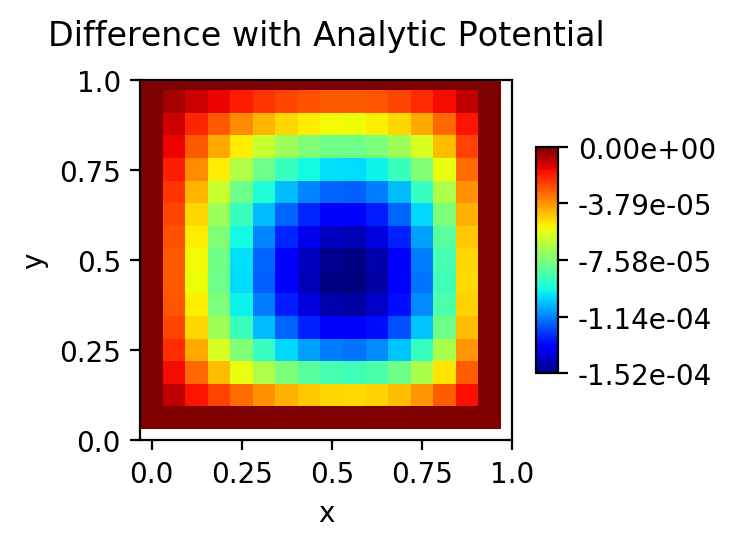

In [38]:
difference = phi-phi_analytic
ticks=np.linspace(difference.min(), difference.max(),5)

fig = plt.figure(figsize=(3,3), dpi=200)
ax = plt.imshow(difference[::-1,:], cmap='jet') #flip the phi to consistent with the figures above
plt.title("Difference with Analytic Potential", y=1.05)
plt.xlabel('x')
plt.ylabel('y')
plt.xticks(np.linspace(0,N,5), np.linspace(0,L,5))
plt.yticks(np.linspace(0,N,5), np.flip(np.linspace(0,L,5))) # flip the y axis

fig.colorbar(ax, shrink=0.5, aspect=10, ticks=ticks, format='%.2e')
# plt.savefig("/home/lab/Guan_Ming/Computational_Astrophysics/Homework/HW3/Problem_1_Simulated_v.s._Analytic_Potential_Difference_N=256_criteria=1.00000000e-21.png", bbox_inches='tight', dpi=200, pad_inches=0.05)
plt.show()

### Lattice Size v.s. Error, Iterations, Total Time

In [33]:
L = 1.0
N_range = np.array([16, 32, 64, 128, 256])
for mode in ['jacobi']:
    error_analytic_record = []
    total_time_record = []
    iteration_record = []
    for N in N_range:
        k = 2.0*np.pi/N
        x = np.arange(0,N)
        y = np.arange(0,N)
        xx,yy= np.meshgrid(x,y)

        phi_analytic = np.exp(-k*xx)*np.sin(k*yy)
        # phi_analytic = (1.0-yy)

        phi = np.zeros(N*N)
        rho = np.zeros(N*N)
        boundary = ((yy%N==0) | (yy%N==N-1) | (xx%N==0) | (xx%N==N-1)).ravel()
        phi[boundary] = phi_analytic.ravel()[boundary]
        iteration = 0
        iteration_max = 4000000
        dx = L/N
        show_error_interval = 100

        neighbor_r = np.arange(N*N)
        neighbor_l = np.arange(N*N)
        neighbor_u = np.arange(N*N)
        neighbor_d = np.arange(N*N)
        neighbor_r = N*(neighbor_r//N) + (neighbor_r%N+1)%N
        neighbor_l = N*(neighbor_l//N) + (neighbor_l%N+N-1)%N
        neighbor_u = N*((neighbor_u//N+1)%N) + neighbor_u%N
        neighbor_d = N*((neighbor_d//N+N-1)%N) + neighbor_d%N

        # criteria = CALCULATE_CRITERIA(phi_analytic.ravel(), rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
        criteria = 1e-21
        error = CALCULATE_CRITERIA(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
        print("Lattice size = %d using %s scheme:"%(N, mode))
        if mode=='jacobi':
            phi_copy = phi.copy()
            flag = True
            #     idx_boundary = boundary==False
            idx_not_boundary = np.argwhere(boundary==False).reshape(-1)
        elif mode=='gauss_seidel' or mode=='SOR':
            idx_all = np.argwhere(boundary==False).reshape(-1)
            idx_even = idx_all[idx_all%2==0]
            idx_odd = idx_all[idx_all%2==1]
            if mode == 'SOR':
                omega = 1.33
        start = time.time()
        while error>criteria and iteration<iteration_max:
            if mode=='jacobi':
                if flag:
                    phi_copy[boundary==False] = LAPLACIAN_JACOBI(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_not_boundary)
                    error = CALCULATE_CRITERIA(phi_copy, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
                else:
                    phi[boundary==False] = LAPLACIAN_JACOBI(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_not_boundary)
                    error = CALCULATE_CRITERIA(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
                flag = not flag
            elif mode=='gauss_seidel':
                phi = LAPLACIAN_GAUSS_SEIDEL(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_even, idx_odd)
                error = CALCULATE_CRITERIA(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
            else:
                phi = LAPLACIAN_SUCCESSIVE_OVER_RELAXATION(phi, omega, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_even, idx_odd)
                error = CALCULATE_CRITERIA(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
            iteration += 1
    #         if iteration%show_error_interval == 0:
    #             print("Iteration = %d, error = %.4e , criteria = %.4e ."%(iteration, error, criteria))
        if mode=='jacobi':
            if flag:
                phi = phi.copy()
        end = time.time()
        iteration_record.append(iteration)
        error_analytic_record.append((((phi-phi_analytic.ravel())**2).mean())**0.5)
        total_time_record.append(end-start)
        print("\tSimulation of %s scheme ends. Total %.2f s is spent."%(mode, end-start))
        print("\tError %.4e has been reached, total iterations is %d ."%(error, iteration))
        print("\tError with analytic solution is %.8e ."%error_analytic_record[-1])
    #     phi = np.array(phi.reshape(N,N))

    data = np.vstack((np.array(N_range),np.array(iteration_record), np.array(error_analytic_record), \
                      np.array(total_time_record))).T
    with open('Error_vs_Lattice_Size_%s_Criteria=%.8e.txt'%(mode,criteria), 'w') as f:
        np.savetxt(f, data, fmt="%.8e",\
                   header='Lattice Size\tIteration(s)\tError\tTotal_Time (s)',\
                   footer='Stopping Criteria: %.8e'%criteria)

Lattice size = 16 using jacobi scheme:
	Simulation of jacobi scheme ends. Total 0.06 s is spent.
	Error 9.7639e-22 has been reached, total iterations is 2029 .
	Error with analytic solution is 1.64406205e-03 .
Lattice size = 32 using jacobi scheme:
	Simulation of jacobi scheme ends. Total 0.39 s is spent.
	Error 9.9025e-22 has been reached, total iterations is 8347 .
	Error with analytic solution is 4.32943368e-04 .
Lattice size = 64 using jacobi scheme:
	Simulation of jacobi scheme ends. Total 3.51 s is spent.
	Error 9.9867e-22 has been reached, total iterations is 33207 .
	Error with analytic solution is 1.10761037e-04 .
Lattice size = 128 using jacobi scheme:
	Simulation of jacobi scheme ends. Total 43.42 s is spent.
	Error 9.9970e-22 has been reached, total iterations is 130083 .
	Error with analytic solution is 2.79882493e-05 .
Lattice size = 256 using jacobi scheme:
	Simulation of jacobi scheme ends. Total 659.10 s is spent.
	Error 9.9971e-22 has been reached, total iterations is

In [34]:
scheme_list = []
data_list = []
for file in os.listdir('./'):
    if "Error" in file:
        if 'jacobi' in file:
            scheme_list.append('Jacobi')
            data_list.append(np.loadtxt('%s'%file))
        elif 'gauss_seidel' in file:
            scheme_list.append('Gauss-Seidel')
            data_list.append(np.loadtxt('%s'%file))
        elif 'SOR' in file:
            scheme_list.append('SOR')
            data_list.append(np.loadtxt('%s'%file))
dict_data = dict(zip(scheme_list, data_list))

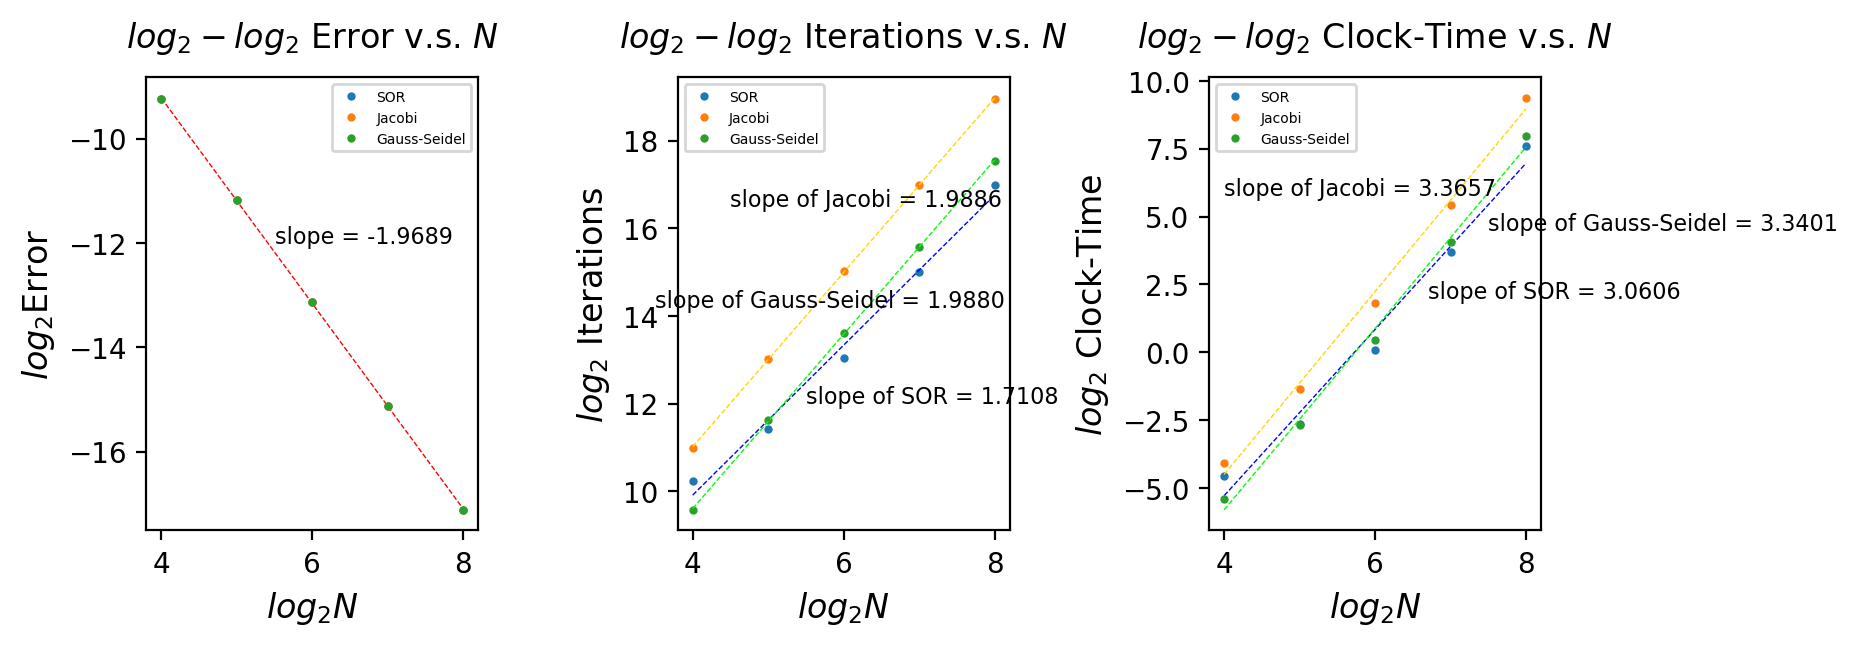

In [35]:
from scipy.optimize import curve_fit

def linear_fit(x, a, b):
    return a*x+b

count = 0 
fig = plt.figure(figsize=(3*3,3), dpi=200)
plt.subplots_adjust(wspace=0.6)
ax_1 = plt.subplot(131)
ax_2 = plt.subplot(132)
ax_3 = plt.subplot(133)
for scheme in list(dict_data.keys()):
    data_lattice_size = np.log2(dict_data[scheme][:,0])
    data_iteration = np.log2(dict_data[scheme][:,1])
    data_error = np.log2(dict_data[scheme][:,2])
    data_total_time = np.log2(dict_data[scheme][:,3])
    
    ax_1.plot(data_lattice_size, data_error, lw=0.0, marker='o', markersize=2.0, label="%s"%scheme)
    if count==0:
        prop, pocp = curve_fit(linear_fit, data_lattice_size, data_error)
        ax_1.plot(data_lattice_size, prop[0]*data_lattice_size+prop[1], lw = 0.5, ls='--', c='red')
        ax_1.text(5.5, -12.0,"slope = %.4f"%prop[0], fontsize=8.0)
    
    ax_2.plot(data_lattice_size, data_iteration, lw=0.0, marker='o', markersize=2.0, label="%s"%scheme)
    prop, pocp = curve_fit(linear_fit, data_lattice_size, data_iteration)
    
    if scheme == 'SOR':
        ax_2.plot(data_lattice_size, prop[0]*data_lattice_size+prop[1], lw = 0.5, ls='--', c='blue')
        ax_2.text(5.5, 12.0,"slope of %s = %.4f"%(scheme, prop[0]), fontsize=8.0)
    elif scheme == 'Gauss-Seidel':
        ax_2.plot(data_lattice_size, prop[0]*data_lattice_size+prop[1], lw = 0.5, ls='--', c='lime')
        ax_2.text(3.5, 14.2,"slope of %s = %.4f"%(scheme, prop[0]), fontsize=8.0)
    else:
        ax_2.plot(data_lattice_size, prop[0]*data_lattice_size+prop[1], lw = 0.5, ls='--', c='gold')
        ax_2.text(4.5, 16.5,"slope of %s = %.4f"%(scheme, prop[0]), fontsize=8.0)
    ax_3.plot(data_lattice_size, data_total_time, lw=0.0, marker='o', markersize=2.0, label="%s"%scheme)    
    prop, pocp = curve_fit(linear_fit, data_lattice_size, data_total_time)
    
    if scheme == 'SOR':
        ax_3.plot(data_lattice_size, prop[0]*data_lattice_size+prop[1], lw = 0.5, ls='--', c='blue')
        ax_3.text(6.7, 2.0,"slope of %s = %.4f"%(scheme, prop[0]), fontsize=8.0)
    elif scheme == 'Gauss-Seidel':
        ax_3.plot(data_lattice_size, prop[0]*data_lattice_size+prop[1], lw = 0.5, ls='--', c='lime')
        ax_3.text(7.5, 4.5,"slope of %s = %.4f"%(scheme, prop[0]), fontsize=8.0)
    else:
        ax_3.plot(data_lattice_size, prop[0]*data_lattice_size+prop[1], lw = 0.5, ls='--', c='gold')
        ax_3.text(4.0, 5.8,"slope of %s = %.4f"%(scheme, prop[0]), fontsize=8.0)
    count += 1
ax_1.set_xlabel('$log_2N$', fontsize=12.)
ax_1.set_ylabel('$log_2$Error', fontsize=12.)
ax_1.set_title('$log_2-log_2$ Error v.s. $N$',y=1.03)
ax_1.legend(loc='upper right', prop={'size':5.0})
ax_2.set_xlabel('$log_2N$', fontsize=12.)
ax_2.set_ylabel('$log_2$ Iterations', fontsize=12.)
ax_2.set_title('$log_2-log_2$ Iterations v.s. $N$',y=1.03)
ax_2.legend(loc='upper left', prop={'size':5.0})
ax_3.set_xlabel('$log_2N$', fontsize=12.)
ax_3.set_ylabel('$log_2$ Clock-Time', fontsize=12.)
ax_3.set_title('$log_2-log_2$ Clock-Time v.s. $N$',y=1.03)
ax_3.legend(loc='upper left', prop={'size':5.0})
plt.savefig("/home/lab/Guan_Ming/Computational_Astrophysics/Homework/HW3/Problem_1_lattice_size_v.s.error_iterations_clock-time.png", bbox_inches='tight', dpi=200, pad_inches=0.05)

### Optimal $\omega$ Test

In [ ]:
L = 1.0
iteration_max = 1000000
criteria = 1.e-21
N_range = np.array([16, 32, 64, 128])
# show_error_interval = 10000

try: 
    os.makedirs('./Optimal_Omega_Test_Fixed_Boundary_L=1')
except:
    print("Folder already existed!")
path = './Optimal_Omega_Test_Fixed_Boundary_L=1/'

for N in N_range:
    k = 2.0*np.pi*3.0/N
    x = np.arange(0,N)
    y = np.arange(0,N)
    xx,yy= np.meshgrid(x,y)

    phi_analytic = np.exp(-k*xx)*np.sin(k*yy)

    rho = np.zeros(N*N)
    boundary = ((yy%N==0) | (yy%N==N-1) | (xx%N==0) | (xx%N==N-1)).ravel()
    
    dx = L/N
    
    omega_range = np.arange(0.25, 1.33, 0.01)

    neighbor_r = np.arange(N*N)
    neighbor_l = np.arange(N*N)
    neighbor_u = np.arange(N*N)
    neighbor_d = np.arange(N*N)
    neighbor_r = N*(neighbor_r//N) + (neighbor_r%N+1)%N
    neighbor_l = N*(neighbor_l//N) + (neighbor_l%N+N-1)%N
    neighbor_u = N*((neighbor_u//N+1)%N) + neighbor_u%N
    neighbor_d = N*((neighbor_d//N+N-1)%N) + neighbor_d%N

    idx_all = np.argwhere(boundary==False).reshape(-1)
    idx_even = idx_all[idx_all%2==0]
    idx_odd = idx_all[idx_all%2==1]

    iteration_record = []
    total_time_record = []
    error_record = []

    print("Test the optimal omega for SOR scheme with N=%d ."%N)
    for omega in omega_range:
        ### reinitialize the field and parameters
        phi = np.zeros(N*N)
        phi[boundary] = phi_analytic.ravel()[boundary]
        iteration = 0
        error = CALCULATE_CRITERIA(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
        ###

        start = time.time()
        while error>criteria and iteration<iteration_max: 
            phi = LAPLACIAN_SUCCESSIVE_OVER_RELAXATION(phi, omega, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d, idx_even, idx_odd)
            error = CALCULATE_CRITERIA(phi, rho, neighbor_r, neighbor_l, neighbor_u, neighbor_d)
            iteration += 1
#             if iteration%show_error_interval == 0:
#                 print("\tIteration = %d, error = %.4e ."%(iteration, error))
        end = time.time()
        print("\tSimulation of omega = %.4e ends. Total %.2f s is spent."%(omega, end-start))
        print("\tError %.4e has been reached, total iterations is %d ."%(error, iteration))
        iteration_record.append(iteration)
        total_time_record.append(end-start)
        error_record.append(error)
        
    error_record = np.array(error_record)
    iteration_record = np.array(iteration_record)
    total_time_record = np.array(total_time_record)

    data = np.vstack((omega_range, iteration_record,error_record, total_time_record)).T
    np.savetxt('%sN=%d_criteria=%.8e_optimal_omega_record.txt'%(path, N, criteria), data, fmt="%.8e",\
               header='Omega\tIteration(s)\tError\tTotal_Time (s)',\
               footer='Stopping Criteria: %.8e'%criteria)

Folder already existed!
Test the optimal omega for SOR scheme with N=16 .
	Simulation of omega = 2.5000e-01 ends. Total 0.13 s is spent.
	Error 9.9841e-22 has been reached, total iterations is 3481 .
	Simulation of omega = 2.6000e-01 ends. Total 0.12 s is spent.
	Error 9.9862e-22 has been reached, total iterations is 3338 .
	Simulation of omega = 2.7000e-01 ends. Total 0.11 s is spent.
	Error 9.9370e-22 has been reached, total iterations is 3206 .
	Simulation of omega = 2.8000e-01 ends. Total 0.11 s is spent.
	Error 9.9435e-22 has been reached, total iterations is 3083 .
	Simulation of omega = 2.9000e-01 ends. Total 0.11 s is spent.
	Error 9.8801e-22 has been reached, total iterations is 2969 .
	Simulation of omega = 3.0000e-01 ends. Total 0.10 s is spent.
	Error 9.9007e-22 has been reached, total iterations is 2862 .
	Simulation of omega = 3.1000e-01 ends. Total 0.10 s is spent.
	Error 9.9075e-22 has been reached, total iterations is 2762 .
	Simulation of omega = 3.2000e-01 ends. Tota

	Simulation of omega = 9.1000e-01 ends. Total 0.03 s is spent.
	Error 9.8990e-22 has been reached, total iterations is 785 .
	Simulation of omega = 9.2000e-01 ends. Total 0.03 s is spent.
	Error 9.8456e-22 has been reached, total iterations is 774 .
	Simulation of omega = 9.3000e-01 ends. Total 0.03 s is spent.
	Error 9.9163e-22 has been reached, total iterations is 763 .
	Simulation of omega = 9.4000e-01 ends. Total 0.03 s is spent.
	Error 9.5823e-22 has been reached, total iterations is 753 .
	Simulation of omega = 9.5000e-01 ends. Total 0.03 s is spent.
	Error 9.8935e-22 has been reached, total iterations is 742 .
	Simulation of omega = 9.6000e-01 ends. Total 0.03 s is spent.
	Error 9.7880e-22 has been reached, total iterations is 732 .
	Simulation of omega = 9.7000e-01 ends. Total 0.03 s is spent.
	Error 9.7958e-22 has been reached, total iterations is 722 .
	Simulation of omega = 9.8000e-01 ends. Total 0.03 s is spent.
	Error 9.9193e-22 has been reached, total iterations is 712 .


	Simulation of omega = 4.8000e-01 ends. Total 0.41 s is spent.
	Error 9.9751e-22 has been reached, total iterations is 6687 .
	Simulation of omega = 4.9000e-01 ends. Total 0.40 s is spent.
	Error 9.9742e-22 has been reached, total iterations is 6532 .
	Simulation of omega = 5.0000e-01 ends. Total 0.39 s is spent.
	Error 9.9838e-22 has been reached, total iterations is 6383 .
	Simulation of omega = 5.1000e-01 ends. Total 0.38 s is spent.
	Error 9.9870e-22 has been reached, total iterations is 6240 .
	Simulation of omega = 5.2000e-01 ends. Total 0.37 s is spent.
	Error 9.9588e-22 has been reached, total iterations is 6103 .
	Simulation of omega = 5.3000e-01 ends. Total 0.36 s is spent.
	Error 9.9409e-22 has been reached, total iterations is 5971 .
	Simulation of omega = 5.4000e-01 ends. Total 0.36 s is spent.
	Error 9.9796e-22 has been reached, total iterations is 5843 .
	Simulation of omega = 5.5000e-01 ends. Total 0.34 s is spent.
	Error 9.9963e-22 has been reached, total iterations is

	Simulation of omega = 1.1400e+00 ends. Total 0.14 s is spent.
	Error 9.8581e-22 has been reached, total iterations is 2293 .
	Simulation of omega = 1.1500e+00 ends. Total 0.14 s is spent.
	Error 9.8980e-22 has been reached, total iterations is 2265 .
	Simulation of omega = 1.1600e+00 ends. Total 0.14 s is spent.
	Error 9.8525e-22 has been reached, total iterations is 2238 .
	Simulation of omega = 1.1700e+00 ends. Total 0.13 s is spent.
	Error 9.8846e-22 has been reached, total iterations is 2211 .
	Simulation of omega = 1.1800e+00 ends. Total 0.13 s is spent.
	Error 9.9953e-22 has been reached, total iterations is 2184 .
	Simulation of omega = 1.1900e+00 ends. Total 0.13 s is spent.
	Error 9.8401e-22 has been reached, total iterations is 2159 .
	Simulation of omega = 1.2000e+00 ends. Total 0.13 s is spent.
	Error 9.9310e-22 has been reached, total iterations is 2133 .
	Simulation of omega = 1.2100e+00 ends. Total 0.13 s is spent.
	Error 9.9222e-22 has been reached, total iterations is

	Simulation of omega = 7.1000e-01 ends. Total 2.09 s is spent.
	Error 9.9909e-22 has been reached, total iterations is 16324 .
	Simulation of omega = 7.2000e-01 ends. Total 2.06 s is spent.
	Error 9.9911e-22 has been reached, total iterations is 16049 .
	Simulation of omega = 7.3000e-01 ends. Total 2.02 s is spent.
	Error 9.9812e-22 has been reached, total iterations is 15782 .
	Simulation of omega = 7.4000e-01 ends. Total 1.99 s is spent.
	Error 9.9986e-22 has been reached, total iterations is 15521 .
	Simulation of omega = 7.5000e-01 ends. Total 1.95 s is spent.
	Error 9.9915e-22 has been reached, total iterations is 15268 .
	Simulation of omega = 7.6000e-01 ends. Total 1.93 s is spent.
	Error 9.9793e-22 has been reached, total iterations is 15022 .
	Simulation of omega = 7.7000e-01 ends. Total 1.89 s is spent.
	Error 9.9993e-22 has been reached, total iterations is 14781 .
	Simulation of omega = 7.8000e-01 ends. Total 1.87 s is spent.
	Error 9.9992e-22 has been reached, total iterat

	Simulation of omega = 2.8000e-01 ends. Total 71.01 s is spent.
	Error 9.9980e-22 has been reached, total iterations is 180199 .
	Simulation of omega = 2.9000e-01 ends. Total 68.39 s is spent.
	Error 9.9998e-22 has been reached, total iterations is 173520 .
	Simulation of omega = 3.0000e-01 ends. Total 65.91 s is spent.
	Error 9.9994e-22 has been reached, total iterations is 167282 .
	Simulation of omega = 3.1000e-01 ends. Total 63.69 s is spent.
	Error 9.9995e-22 has been reached, total iterations is 161454 .
	Simulation of omega = 3.2000e-01 ends. Total 61.54 s is spent.
	Error 9.9988e-22 has been reached, total iterations is 155987 .
	Simulation of omega = 3.3000e-01 ends. Total 59.48 s is spent.
	Error 9.9977e-22 has been reached, total iterations is 150851 .
	Simulation of omega = 3.4000e-01 ends. Total 57.62 s is spent.
	Error 9.9976e-22 has been reached, total iterations is 146019 .
	Simulation of omega = 3.5000e-01 ends. Total 55.77 s is spent.
	Error 9.9991e-22 has been reache

	Simulation of omega = 9.2000e-01 ends. Total 17.92 s is spent.
	Error 9.9954e-22 has been reached, total iterations is 45515 .
	Simulation of omega = 9.3000e-01 ends. Total 17.68 s is spent.
	Error 9.9996e-22 has been reached, total iterations is 44882 .
	Simulation of omega = 9.4000e-01 ends. Total 17.44 s is spent.
	Error 9.9999e-22 has been reached, total iterations is 44263 .
	Simulation of omega = 9.5000e-01 ends. Total 17.22 s is spent.
	Error 9.9993e-22 has been reached, total iterations is 43657 .
	Simulation of omega = 9.6000e-01 ends. Total 16.95 s is spent.
	Error 9.9979e-22 has been reached, total iterations is 43064 .
	Simulation of omega = 9.7000e-01 ends. Total 16.76 s is spent.
	Error 9.9977e-22 has been reached, total iterations is 42483 .
	Simulation of omega = 9.8000e-01 ends. Total 16.52 s is spent.
	Error 9.9959e-22 has been reached, total iterations is 41914 .
	Simulation of omega = 9.9000e-01 ends. Total 16.29 s is spent.
	Error 9.9994e-22 has been reached, tota

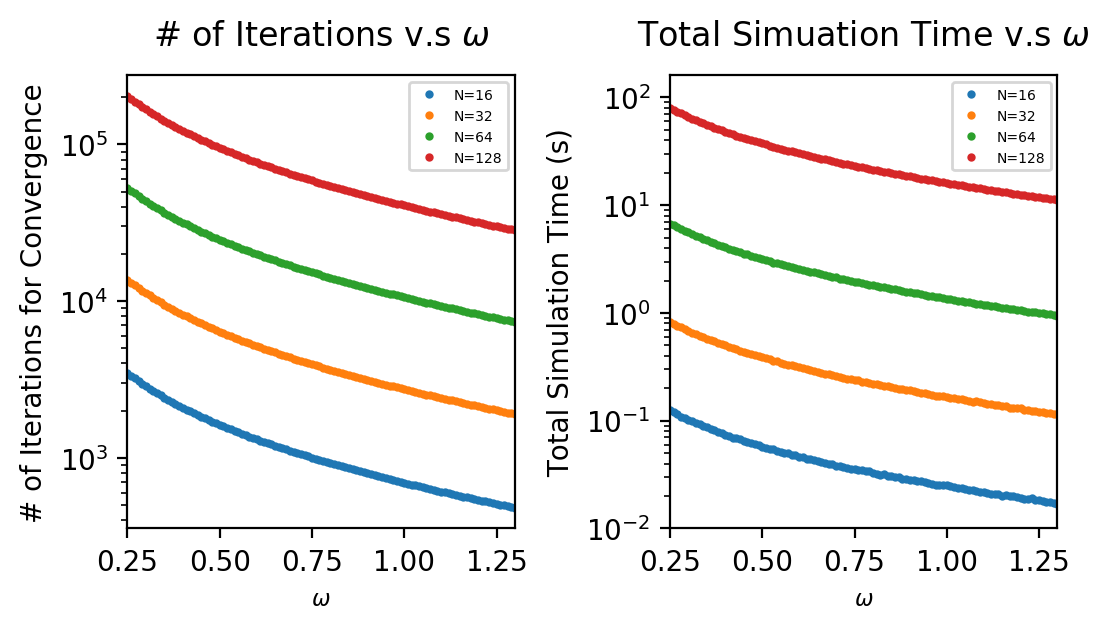

In [22]:
N_list = []
data_list = []
path = './Optimal_Omega_Test_Fixed_Boundary_L=1/'
files = os.listdir(path)

for file in files:
    if '.txt' in file and '1.00000000e-21' in file:
        data = np.loadtxt('%s%s'%(path, file))
        omega_range, iteration_record, error_record, total_time_record = data[:,0], data[:,1], data[:,2], data[:,3]
        criteria = eval(file.split('_')[1].split('=')[-1])
        lattice_size = eval(file.split('_')[0].split('=')[-1])
        data = np.vstack((omega_range[error_record<criteria], iteration_record[error_record<criteria], \
                          total_time_record[error_record<criteria])).T
        N_list.append(lattice_size)
        data_list.append(data)
dict_data = dict(zip(N_list, data_list))

fig = plt.figure(figsize=(2*3,3), dpi=200)
plt.subplots_adjust(wspace=0.4)
ax_1 = plt.subplot(121)
ax_2 = plt.subplot(122)
for N in sorted(list(dict_data.keys())):
    data = dict_data[N]
    ax_1.semilogy(data[:,0], data[:,1], lw=0.0, marker='o', markersize=2.0, label='N=%d'%N)
    ax_2.semilogy(data[:,0], data[:,2], lw=0.0, marker='o', markersize=2.0, label='N=%d'%N)
    
ax_1.set_xlabel('$\omega$', fontsize=8.)
ax_1.set_ylabel('# of Iterations for Convergence')
ax_1.set_title('# of Iterations v.s $\omega$',y=1.03)
ax_1.set_xticks(np.arange(0.0,1.5,0.25))
ax_1.set_xlim([0.25,1.3])
ax_1.legend(loc='upper right', prop={'size':5.0})
ax_2.set_xlabel('$\omega$', fontsize=8.)
ax_2.set_ylabel('Total Simulation Time (s)')
ax_2.set_title('Total Simuation Time v.s $\omega$',y=1.03)
ax_2.set_xticks(np.arange(0.0,1.5,0.25))
ax_2.set_xlim([0.25,1.3])
ax_2.set_ylim([0.01,160])
ax_2.legend(loc='upper right', prop={'size':5.0})
plt.savefig("/home/lab/Guan_Ming/Computational_Astrophysics/Homework/HW3/Problem_2_Optimal_omega_Fixed_Boundary.png", bbox_inches='tight', dpi=200, pad_inches=0.05)
plt.show()

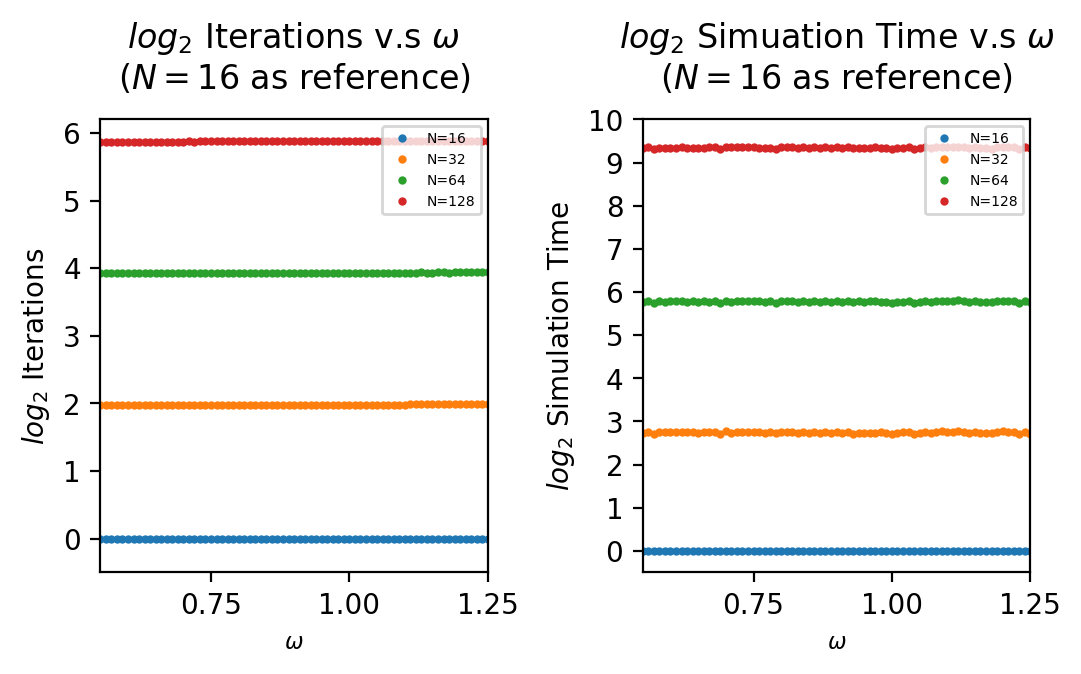

In [19]:
fig = plt.figure(figsize=(2*3,3), dpi=200)
plt.subplots_adjust(wspace=0.4)
ax_1 = plt.subplot(121)
ax_2 = plt.subplot(122)

reference_omega = (dict_data[16][:,0]>=0.25) & (dict_data[16][:,0]<=1.3)
reference_iteration = dict_data[16][reference_omega,1]
reference_time = dict_data[16][reference_omega,2]

for N in [16, 32, 64, 128]:
    data = dict_data[N]
    omega_range = (data[:,0]>=0.25) & (data[:,0]<=1.3)
    ax_1.plot(data[omega_range,0], np.log2(data[omega_range,1]/reference_iteration),\
              lw=0.0, marker='o', markersize=2.0, label='N=%d'%N)
    ax_2.plot(data[omega_range,0], np.log2(data[omega_range,2]/reference_time),\
              lw=0.0, marker='o', markersize=2.0, label='N=%d'%N)
    
ax_1.set_xlabel('$\omega$', fontsize=8.)
ax_1.set_ylabel('$log_2$ Iterations')
ax_1.set_title('$log_2$ Iterations v.s $\omega$\n($N=16$ as reference)',y=1.03)
ax_1.set_xticks(np.arange(0.0,1.5,0.25))
ax_1.set_xlim([0.55,1.25])
ax_1.set_ylim([-0.5,6.2])
ax_1.legend(loc='upper right', prop={'size':5.0})
ax_2.set_xlabel('$\omega$', fontsize=8.)
ax_2.set_ylabel('$log_2$ Simulation Time')
ax_2.set_title('$log_2$ Simuation Time v.s $\omega$\n($N=16$ as reference)',y=1.03)
ax_2.set_xticks(np.arange(0.0,1.5,0.25))
ax_2.set_yticks(np.arange(0.0,11,1.0))
ax_2.set_xlim([0.55,1.25])
ax_2.set_ylim([-0.5,10.])
ax_2.legend(loc='upper right', prop={'size':5.0})
plt.show()    